# Didn't converge, better to fit aborts seperately first

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from joblib import Parallel, delayed
from pyvbmc import VBMC
import corner
from tqdm.notebook import tqdm
import pickle
import random
from scipy.integrate import cumulative_trapezoid as cumtrapz

from time_vary_norm_utils import (
    up_or_down_RTs_fit_fn, cum_pro_and_reactive_time_vary_fn,
    rho_A_t_VEC_fn, up_or_down_RTs_fit_wrt_stim_fn, rho_A_t_fn, cum_A_t_fn,
    CDF_E_minus_small_t_NORM_rate_norm_l_time_varying_fn, rho_E_minus_small_t_NORM_rate_norm_time_varying_fn)
from types import SimpleNamespace
from time_vary_and_norm_simulators import psiam_tied_data_gen_wrapper_rate_norm_fn

In [2]:
######## TEMP ########
def up_or_down_RTs_fit_PA_C_A_given_wrt_t_stim_fn(
        t, bound,
        P_A, C_A,
        ABL, ILD, rate_lambda, T0, theta_E, Z_E, t_E_aff, del_go,
        phi_params, rate_norm_l, 
        is_norm, is_time_vary, K_max):
    
    # t1, t2 - if proactive wins, time range in which EA can hit bound and confirm a choice
    t1 = max(t - t_E_aff, 1e-6)
    t2 = max(t - t_E_aff + del_go, 1e-6)

    # phi(t) and its integral for different times
    if is_time_vary:
        int_phi_t_E_g = int_phi_fn(max(t - t_E_aff + del_go, 1e-6), phi_params.h1, phi_params.a1, phi_params.b1, phi_params.h2, phi_params.a2)

        phi_t_e = phi_t_fn(max(t - t_E_aff, 1e-6), phi_params.h1, phi_params.a1, phi_params.b1, phi_params.h2, phi_params.a2)
        int_phi_t_e = int_phi_fn(max(t - t_E_aff, 1e-6), phi_params.h1, phi_params.a1, phi_params.b1, phi_params.h2, phi_params.a2)

        int_phi_t2 = int_phi_fn(t2, phi_params.h1, phi_params.a1, phi_params.b1, phi_params.h2, phi_params.a2)
        int_phi_t1 = int_phi_fn(t1, phi_params.h1, phi_params.a1, phi_params.b1, phi_params.h2, phi_params.a2)

        if int_phi_t_E_g * int_phi_t_e * int_phi_t2 * int_phi_t1 == 0:
            raise ValueError(
                f'''
                t = {t}, t_E_aff = {t_E_aff}
                t1 = {t1}
                one of them is zero
                int_phi_t_E_g = {int_phi_t_E_g}
                int_phi_t_e = {int_phi_t_e}
                int_phi_t2 = {int_phi_t2}
                int_phi_t1 = {int_phi_t1}

                params  = {phi_params.h1, phi_params.a1, phi_params.b1, phi_params.h2, phi_params.a2}
                '''
                    
                )
    else:
        int_phi_t_E_g = np.nan
        
        phi_t_e = np.nan
        int_phi_t_e = np.nan

        int_phi_t2 = np.nan
        int_phi_t1 = np.nan

    # PA wins and random choice due to EA survival
    P_EA_hits_either_bound = CDF_E_minus_small_t_NORM_rate_norm_l_time_varying_fn(
                                t - t_E_aff + del_go, 1, 
                                ABL, ILD, rate_lambda, T0, theta_E, Z_E, int_phi_t_E_g, rate_norm_l, 
                                is_norm, is_time_vary, K_max)  \
                                + \
                                CDF_E_minus_small_t_NORM_rate_norm_l_time_varying_fn(
                                t - t_E_aff + del_go, -1, 
                                ABL, ILD, rate_lambda, T0, theta_E, Z_E, int_phi_t_E_g, rate_norm_l,
                                is_norm, is_time_vary, K_max)
    
    P_EA_survives = 1 - P_EA_hits_either_bound
    random_readout_if_EA_survives = 0.5 * P_EA_survives
    
    # PA wins and EA hits later
    P_E_plus_cum = CDF_E_minus_small_t_NORM_rate_norm_l_time_varying_fn(
                            t2, bound, 
                            ABL, ILD, rate_lambda, T0, theta_E, Z_E, int_phi_t2, rate_norm_l, 
                            is_norm, is_time_vary, K_max)  \
                            - \
                            CDF_E_minus_small_t_NORM_rate_norm_l_time_varying_fn(
                            t1, bound, 
                            ABL, ILD, rate_lambda, T0, theta_E, Z_E, int_phi_t1, rate_norm_l,
                            is_norm, is_time_vary, K_max)
    

    # EA wins
    P_E_plus = rho_E_minus_small_t_NORM_rate_norm_time_varying_fn(
        t - t_E_aff, bound, ABL, ILD, rate_lambda, T0, theta_E, Z_E, phi_t_e, int_phi_t_e, 
        rate_norm_l, is_norm, is_time_vary, K_max)
    

    

    return (P_A*(random_readout_if_EA_survives + P_E_plus_cum) + P_E_plus*(1-C_A))


In [3]:
exp_df = pd.read_csv('../outExp.csv')

# remove wrong rows 
count = ((exp_df['RTwrtStim'].isna()) & (exp_df['abort_event'] == 3)).sum()
print("Number of rows where RTwrtStim is NaN and abort_event == 3:", count)
exp_df = exp_df[~((exp_df['RTwrtStim'].isna()) & (exp_df['abort_event'] == 3))].copy()

# comparable batch
exp_df_batch = exp_df[
    (exp_df['batch_name'] == 'Comparable') &
    (exp_df['LED_trial'].isin([np.nan, 0]))
]

# aborts and valid
df_valid_and_aborts = exp_df_batch[
    (exp_df_batch['success'].isin([1,-1])) |
    (exp_df_batch['abort_event'] == 3)
].copy()

## choice and acc columns
# 1 is right , -1 is left
df_valid_and_aborts['choice'] = df_valid_and_aborts['response_poke'].apply(lambda x: 1 if x == 3 else (-1 if x == 2 else random.choice([1, -1])))
# 1 or 0 if the choice was correct or not
df_valid_and_aborts['accuracy'] = (df_valid_and_aborts['ILD'] * df_valid_and_aborts['choice']).apply(lambda x: 1 if x > 0 else 0)

## df used for fitting - valid trials < 1s + stim
df_valid_less_than_1 = df_valid_and_aborts[
    (df_valid_and_aborts['success'].isin([1,-1])) & 
    (df_valid_and_aborts['RTwrtStim'] < 1) &
    (df_valid_and_aborts['RTwrtStim'] > 0)
]

# find ABL and ILD
ABL_arr = df_valid_and_aborts['ABL'].unique()
ILD_arr = df_valid_and_aborts['ILD'].unique()


# sort ILD arr in ascending order
ILD_arr = np.sort(ILD_arr)
ABL_arr = np.sort(ABL_arr)

print('ABL:', ABL_arr)
print('ILD:', ILD_arr)

Number of rows where RTwrtStim is NaN and abort_event == 3: 16
ABL: [10 25 40 50 55 70]
ILD: [-8.   -4.   -2.25 -1.25 -0.5   0.    0.5   1.25  2.25  4.    8.  ]


# vbmc

In [4]:
is_norm = True
is_time_vary = False
phi_params_obj = np.nan

In [5]:
proactive_trunc_time = 0.3
K_max = 10

In [6]:
V_A = 3.282
theta_A = 3.779
t_A_aff = -0.266

## loglike fn

In [7]:
def compute_loglike(row, rate_lambda, T_0, theta_E, Z_E, t_E_aff, del_go, rate_norm_l):
    
    rt = row['TotalFixTime']
    t_stim = row['intended_fix']
    
    
    ILD = row['ILD']
    ABL = row['ABL']
    choice = row['choice']

    pdf = up_or_down_RTs_fit_fn(
            rt, choice,
            V_A, theta_A, t_A_aff,
            t_stim, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_E_aff, del_go,
            phi_params_obj, rate_norm_l, 
            is_norm, is_time_vary, K_max)

    trunc_factor_p_joint = cum_pro_and_reactive_time_vary_fn(
                            t_stim + 1, proactive_trunc_time,
                            V_A, theta_A, t_A_aff,
                            t_stim, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_E_aff,
                            phi_params_obj, rate_norm_l, 
                            is_norm, is_time_vary, K_max) \
                            - \
                            cum_pro_and_reactive_time_vary_fn(
                            t_stim, proactive_trunc_time,
                            V_A, theta_A, t_A_aff,
                            t_stim, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_E_aff,
                            phi_params_obj, rate_norm_l, 
                            is_norm, is_time_vary, K_max)
                           

    pdf /= (trunc_factor_p_joint + 1e-20)
    pdf = max(pdf, 1e-50)
    if np.isnan(pdf):
        print(f'row["abort_event"] = {row["abort_event"]}')
        print(f'row["RTwrtStim"] = {row["RTwrtStim"]}')
        raise ValueError(f'nan pdf rt = {rt}, t_stim = {t_stim}')
    return np.log(pdf)
    
    


def vbmc_loglike_fn(params):
    rate_lambda, T_0, theta_E, w, t_E_aff, del_go, rate_norm_l = params
    Z_E = (w - 0.5) * 2 * theta_E
    all_loglike = Parallel(n_jobs=30)(delayed(compute_loglike)(row, rate_lambda, T_0, theta_E, Z_E, t_E_aff, del_go, rate_norm_l)\
                                       for _, row in df_valid_less_than_1.iterrows() )
    return np.sum(all_loglike)


## priors

In [8]:
rate_lambda_bounds = [0.5, 5]
T_0_bounds = [50e-3, 800e-3]
theta_E_bounds = [1, 15]
w_bounds = [0.3, 0.7]
t_E_aff_bounds = [0.01, 0.2]
del_go_bounds = [0, 0.2]
rate_norm_bounds = [0, 2]

rate_lambda_plausible_bounds = [1, 3]
T_0_plausible_bounds = [150e-3, 400e-3]
theta_E_plausible_bounds = [1.5, 10]
w_plausible_bounds = [0.4, 0.6]
t_E_aff_plausible_bounds = [0.03, 0.09]
del_go_plausible_bounds = [0.05, 0.15]
rate_norm_plausible_bounds = [0.8, 0.99]

In [9]:
def trapezoidal_logpdf(x, a, b, c, d):
    if x < a or x > d:
        return -np.inf  # Logarithm of zero
    area = ((b - a) + (d - c)) / 2 + (c - b)
    h_max = 1.0 / area  # Height of the trapezoid to normalize the area to 1
    
    if a <= x <= b:
        pdf_value = ((x - a) / (b - a)) * h_max
    elif b < x < c:
        pdf_value = h_max
    elif c <= x <= d:
        pdf_value = ((d - x) / (d - c)) * h_max
    else:
        pdf_value = 0.0  # This case is redundant due to the initial check

    if pdf_value <= 0.0:
        return -np.inf
    else:
        return np.log(pdf_value)
    

def vbmc_prior_fn(params):
    rate_lambda, T_0, theta_E, w, t_E_aff, del_go, rate_norm_l = params

    rate_lambda_logpdf = trapezoidal_logpdf(
        rate_lambda,
        rate_lambda_bounds[0],
        rate_lambda_plausible_bounds[0],
        rate_lambda_plausible_bounds[1],
        rate_lambda_bounds[1]
    )
    
    T_0_logpdf = trapezoidal_logpdf(
        T_0,
        T_0_bounds[0],
        T_0_plausible_bounds[0],
        T_0_plausible_bounds[1],
        T_0_bounds[1]
    )
    
    theta_E_logpdf = trapezoidal_logpdf(
        theta_E,
        theta_E_bounds[0],
        theta_E_plausible_bounds[0],
        theta_E_plausible_bounds[1],
        theta_E_bounds[1]
    )
    
    w_logpdf = trapezoidal_logpdf(
        w,
        w_bounds[0],
        w_plausible_bounds[0],
        w_plausible_bounds[1],
        w_bounds[1]
    )
    
    t_E_aff_logpdf = trapezoidal_logpdf(
        t_E_aff,
        t_E_aff_bounds[0],
        t_E_aff_plausible_bounds[0],
        t_E_aff_plausible_bounds[1],
        t_E_aff_bounds[1]
    )
    
    del_go_logpdf = trapezoidal_logpdf(
        del_go,
        del_go_bounds[0],
        del_go_plausible_bounds[0],
        del_go_plausible_bounds[1],
        del_go_bounds[1]
    )
    rate_norm_l_logpdf = trapezoidal_logpdf(
        rate_norm_l,
        rate_norm_bounds[0],
        rate_norm_plausible_bounds[0],
        rate_norm_plausible_bounds[1],
        rate_norm_bounds[1]
    )
    
    return (
        rate_lambda_logpdf +
        T_0_logpdf +
        theta_E_logpdf +
        w_logpdf +
        t_E_aff_logpdf +
        del_go_logpdf + 
        rate_norm_l_logpdf
    )

## prior + loglike

In [10]:
def vbmc_joint_fn(params):
    priors = vbmc_prior_fn(params)
    loglike = vbmc_loglike_fn(params)

    return priors + loglike

# run vbmc

In [11]:
# Add bounds for all parameters (order: V_A, theta_A, t_A_aff, rate_lambda, T_0, theta_E, w, t_E_aff, del_go)
lb = np.array([
    rate_lambda_bounds[0],
    T_0_bounds[0],
    theta_E_bounds[0],
    w_bounds[0],
    t_E_aff_bounds[0],
    del_go_bounds[0],
    rate_norm_bounds[0]
])

ub = np.array([
    rate_lambda_bounds[1],
    T_0_bounds[1],
    theta_E_bounds[1],
    w_bounds[1],
    t_E_aff_bounds[1],
    del_go_bounds[1],
    rate_norm_bounds[1]
])

plb = np.array([
    rate_lambda_plausible_bounds[0],
    T_0_plausible_bounds[0],
    theta_E_plausible_bounds[0],
    w_plausible_bounds[0],
    t_E_aff_plausible_bounds[0],
    del_go_plausible_bounds[0],
    rate_norm_plausible_bounds[0]
])

pub = np.array([
    rate_lambda_plausible_bounds[1],
    T_0_plausible_bounds[1],
    theta_E_plausible_bounds[1],
    w_plausible_bounds[1],
    t_E_aff_plausible_bounds[1],
    del_go_plausible_bounds[1],
    rate_norm_plausible_bounds[1]
])

# Initialize with random values within plausible bounds
np.random.seed(42)
# rate_lambda_0 = np.random.uniform(*rate_lambda_plausible_bounds)
# T_0_0 = np.random.uniform(*T_0_plausible_bounds)
# theta_E_0 = np.random.uniform(*theta_E_plausible_bounds)
# w_0 = np.random.uniform(*w_plausible_bounds)
# t_E_aff_0 = np.random.uniform(*t_E_aff_plausible_bounds)
# del_go_0 = np.random.uniform(*del_go_plausible_bounds)

rate_lambda_0 = 2.3
T_0_0 = 100 * 1e-3
theta_E_0 = 3
w_0 = 0.51
t_E_aff_0 = 0.071
del_go_0 = 0.19
rate_norm_l_0 = 0.95

x_0 = np.array([
    rate_lambda_0,
    T_0_0,
    theta_E_0,
    w_0,
    t_E_aff_0,
    del_go_0,
    rate_norm_l_0
])

# Run VBMC
vbmc = VBMC(vbmc_joint_fn, x_0, lb, ub, plb, pub, options={'display': 'on'})
vp, results = vbmc.optimize()

Reshaping x0 to row vector.
Reshaping lower bounds to (1, 7).
Reshaping upper bounds to (1, 7).
Reshaping plausible lower bounds to (1, 7).
Reshaping plausible upper bounds to (1, 7).
vbmc:InitialPointsOutsidePB. The starting points X0 are not inside the provided plausible bounds PLB and PUB. Expanding the plausible bounds...
Beginning variational optimization assuming EXACT observations of the log-joint.
 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     0         10      -21189.67     19316.18 87171130882384510976.00        2        inf     start warm-up
     1         15       -5070.82     23345.25      1961.22        2        inf     
     2         20       22321.51      1956.51     15935.72        2   2.99e+05     
     3         25       21444.85       556.46      3409.04        2   4.77e+04     
     4         30       21340.13       166.06      1743.24        2   2.26e+04     
     5         35       22428.75       951.95   1536128.4

In [ ]:

# vbmc.save('ONLY_norm_vbmc_fit.pkl')

In [13]:
vp_samples.shape

(100000, 7)

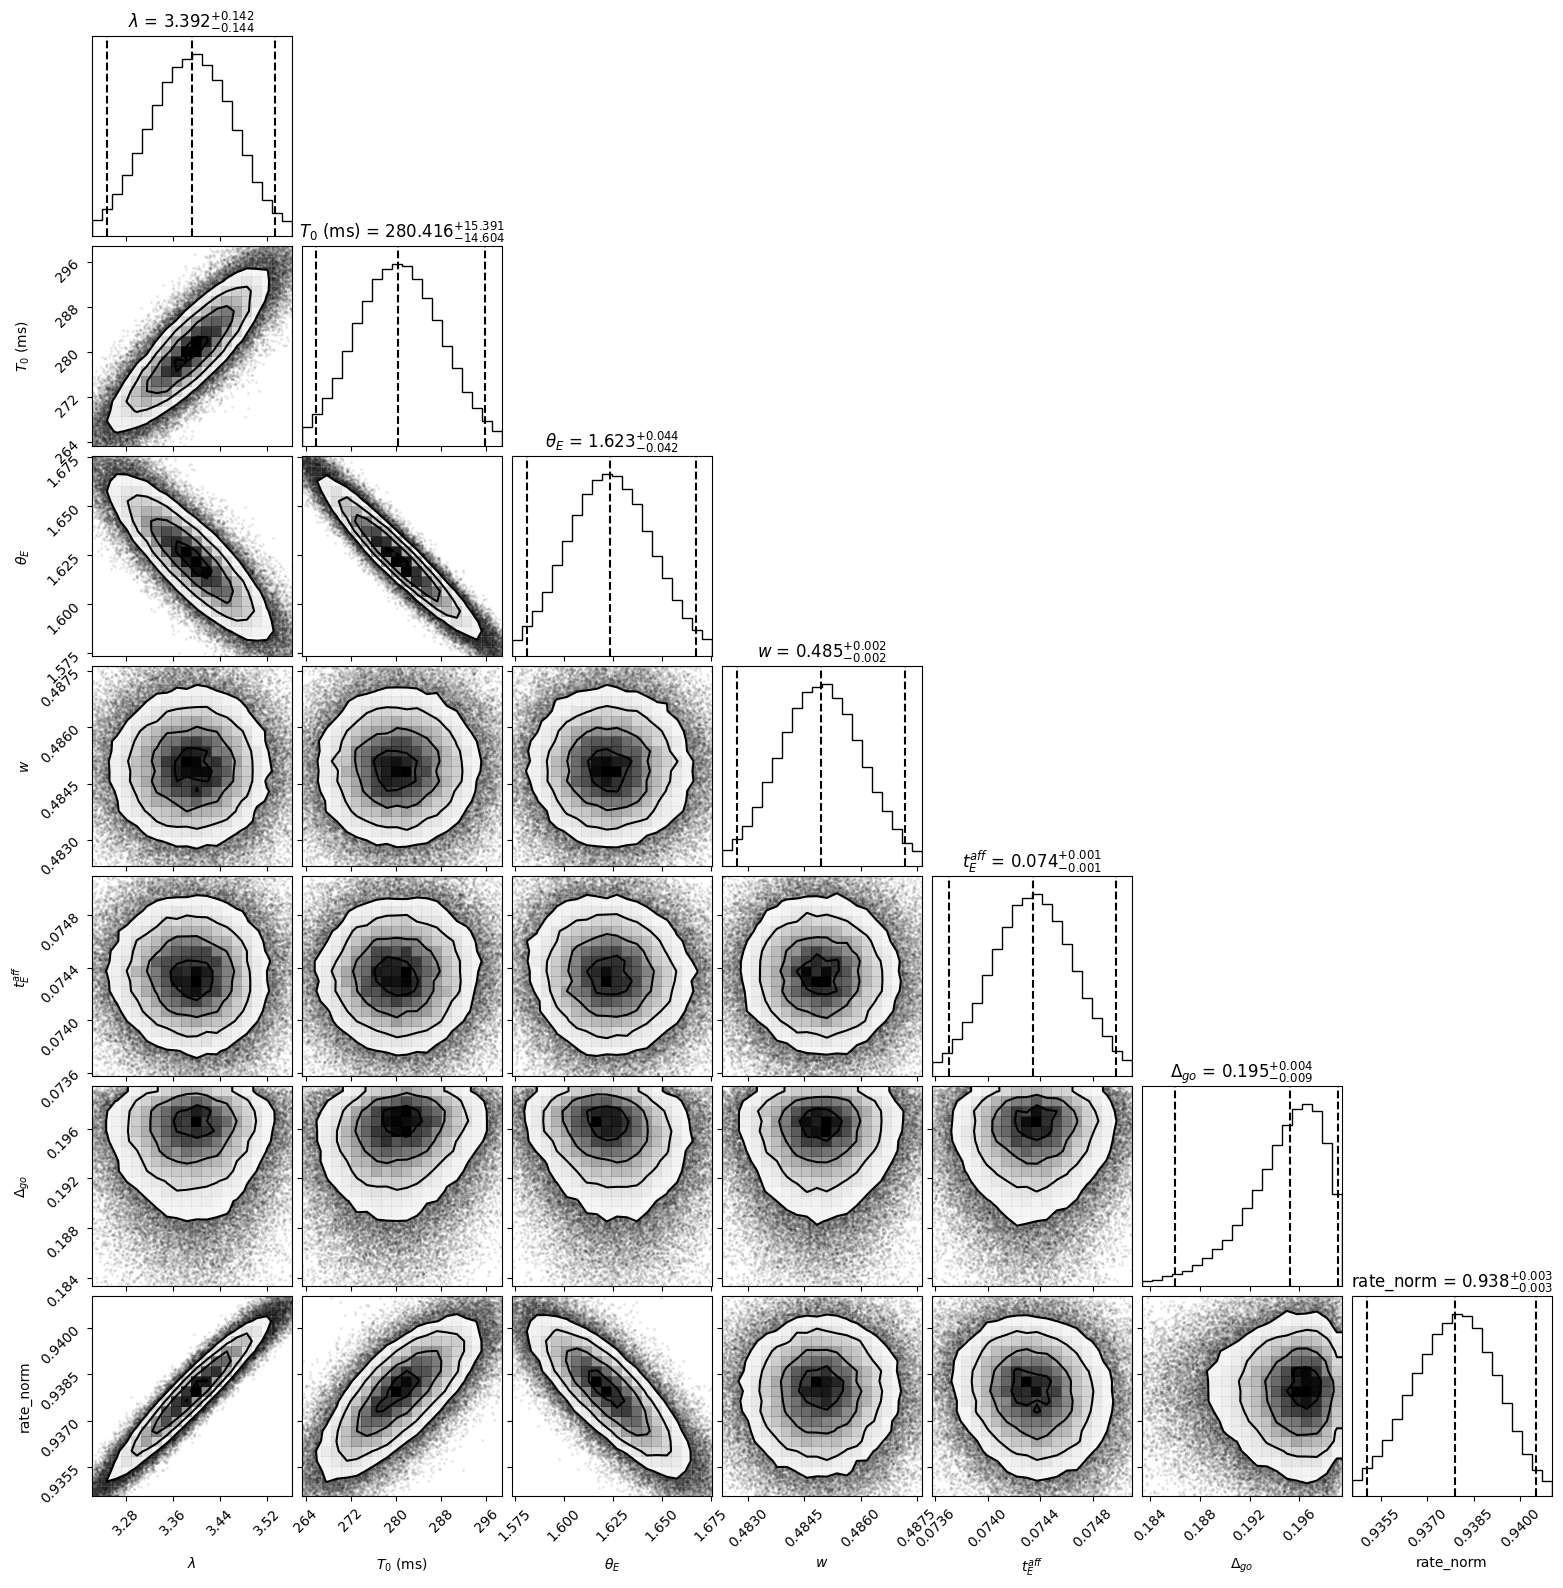

In [14]:
# Sample from the VBMC posterior (returns tuple: samples, log weights)
vp_samples = vp.sample(int(1e5))[0]

# Convert T_0 to ms (T_0 is at index 4)
vp_samples[:, 1] *= 1e3

# Parameter labels (order matters!)
param_labels = [
    r'$\lambda$',       # 3
    r'$T_0$ (ms)',      # 4
    r'$\theta_E$',      # 5
    r'$w$',             # 6
    r'$t_E^{aff}$',     # 7
    r'$\Delta_{go}$',  # 8,
    r'rate_norm'        # 9
]

# Compute 1st and 99th percentiles for each param to restrict range
percentiles = np.percentile(vp_samples, [1, 99], axis=0)
_ranges = [(percentiles[0, i], percentiles[1, i]) for i in range(vp_samples.shape[1])]

# Create the corner plot
fig = corner.corner(
    vp_samples,
    labels=param_labels,
    show_titles=True,
    quantiles=[0.025, 0.5, 0.975],
    range=_ranges,
    title_fmt=".3f"
)

# Convert T_0 back to original units if needed
vp_samples[:, 1] /= 1e3

plt.show()

In [15]:
vbmc.save('comparabale_tied_rate_norm_l_params_fit.pkl')

# Simulation diagnostics

## params

In [16]:
rate_lambda = vp_samples[:, 0].mean()
T_0 = vp_samples[:, 1].mean()
theta_E = vp_samples[:, 2].mean()
w = vp_samples[:, 3].mean()
Z_E = (w - 0.5) * 2 * theta_E
t_E_aff = vp_samples[:, 4].mean()
del_go = vp_samples[:, 5].mean()
rate_norm_l = vp_samples[:, 6].mean()

# Print them out
print("Posterior Means:")
print(f"rate_lambda  = {rate_lambda:.5f}")
print(f"T_0 (ms)      = {1e3*T_0:.5f}")
print(f"theta_E       = {theta_E:.5f}")
print(f"Z_E           = {Z_E:.5f}")
print(f"t_E_aff       = {1e3*t_E_aff:.5f} ms")
print(f"del_go   = {del_go:.5f}")
print(f"rate_norm_l   = {rate_norm_l:.5f}")


Posterior Means:
rate_lambda  = 3.39178
T_0 (ms)      = 280.50775
theta_E       = 1.62364
Z_E           = -0.04892
t_E_aff       = 74.34376 ms
del_go   = 0.19458
rate_norm_l   = 0.93786


## simulate

In [ ]:
# sample t-stim
N_sim = int(1e6)

t_stim_samples = df_valid_and_aborts['intended_fix'].sample(N_sim, replace=True).values
ABL_samples = df_valid_and_aborts['ABL'].sample(N_sim, replace=True).values
ILD_samples = np.random.choice(np.setdiff1d(df_valid_and_aborts['ILD'].unique(), [0]), size=N_sim, replace=True)

N_print = int(N_sim / 5)
dt  = 1e-4

sim_results = Parallel(n_jobs=30)(
    delayed(psiam_tied_data_gen_wrapper_rate_norm_fn)(
        V_A, theta_A, ABL_samples[iter_num], ILD_samples[iter_num], rate_lambda, T_0, theta_E, Z_E, t_A_aff, t_E_aff, del_go, 
        t_stim_samples[iter_num], rate_norm_l, iter_num, N_print, dt
    ) for iter_num in tqdm(range(N_sim))
)

## prepare valid sim df, data df

In [ ]:
sim_results_df = pd.DataFrame(sim_results)
sim_results_df_valid = sim_results_df[
    (sim_results_df['rt'] > sim_results_df['t_stim']) &
    (sim_results_df['rt'] - sim_results_df['t_stim'] < 1)
].copy()
sim_results_df_valid.loc[:, 'correct'] = (sim_results_df_valid['ILD'] * sim_results_df_valid['choice']).apply(lambda x: 1 if x > 0 else 0)


# remove correct column from df_valid_and_aborts
df_valid_less_than_1 = df_valid_less_than_1.drop(columns=['correct']).copy()
df_led_off_valid_renamed = df_valid_less_than_1.rename(columns = {
    'TotalFixTime': 'rt',
    'intended_fix': 't_stim',
    'accuracy': 'correct'
}).copy()

sim_df_1 = sim_results_df_valid.copy()
data_df_1 = df_led_off_valid_renamed.copy()

## plots

In [ ]:
# theory
N_theory = int(1e3)
t_pts = np.arange(-1, 2, 0.001)
t_stim_samples = df_valid_and_aborts['intended_fix'].sample(N_theory, replace=True).values

P_A_samples = np.zeros((N_theory, len(t_pts)))
for idx, t_stim in enumerate(t_stim_samples):
    P_A_samples[idx, :] = [rho_A_t_fn(t + t_stim - t_A_aff, V_A, theta_A) for t in t_pts]

P_A_mean = np.mean(P_A_samples, axis=0)
C_A_mean = cumtrapz(P_A_mean, t_pts, initial=0)


In [ ]:
bw = 0.02
bins = np.arange(0, 1, bw)
bin_centers = bins[:-1] + (0.5 * bw)
ILD_arr_minus_zero = [x for x in ILD_arr if x != 0]

n_rows = len(ILD_arr_minus_zero)
n_cols = len(ABL_arr)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows), sharey='row')

for i_idx, ILD in enumerate(ILD_arr_minus_zero):
    for a_idx, ABL in enumerate(ABL_arr):
        ax = axs[i_idx, a_idx] if n_rows > 1 else axs[a_idx]

        sim_df_1_ABL_ILD = sim_df_1[(sim_df_1['ABL'] == ABL) & (sim_df_1['ILD'] == ILD)]
        data_df_1_ABL_ILD = data_df_1[(data_df_1['ABL'] == ABL) & (data_df_1['ILD'] == ILD)]

        sim_up = sim_df_1_ABL_ILD[sim_df_1_ABL_ILD['choice'] == 1]
        sim_down = sim_df_1_ABL_ILD[sim_df_1_ABL_ILD['choice'] == -1]
        data_up = data_df_1_ABL_ILD[data_df_1_ABL_ILD['choice'] == 1]
        data_down = data_df_1_ABL_ILD[data_df_1_ABL_ILD['choice'] == -1]

        sim_up_rt = sim_up['rt'] - sim_up['t_stim']
        sim_down_rt = sim_down['rt'] - sim_down['t_stim']
        data_up_rt = data_up['rt'] - data_up['t_stim']
        data_down_rt = data_down['rt'] - data_down['t_stim']

        sim_up_hist, _ = np.histogram(sim_up_rt, bins=bins, density=True)
        sim_down_hist, _ = np.histogram(sim_down_rt, bins=bins, density=True)
        data_up_hist, _ = np.histogram(data_up_rt, bins=bins, density=True)
        data_down_hist, _ = np.histogram(data_down_rt, bins=bins, density=True)

        # Normalize histograms by proportion of trials
        sim_up_hist *= len(sim_up) / len(sim_df_1_ABL_ILD)
        sim_down_hist *= len(sim_down) / len(sim_df_1_ABL_ILD)
        data_up_hist *= len(data_up) / len(data_df_1_ABL_ILD)
        data_down_hist *= len(data_down) / len(data_df_1_ABL_ILD)

        # theory
        trunc_fac_samples = np.zeros((N_theory))

        for idx, t_stim in enumerate(t_stim_samples):
            trunc_fac_samples[idx] = cum_pro_and_reactive_time_vary_fn(
                                t_stim + 1, proactive_trunc_time,
                                V_A, theta_A, t_A_aff,
                                t_stim, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_E_aff,
                                phi_params_obj, rate_norm_l, 
                                is_norm, is_time_vary, K_max) \
                                - \
                                cum_pro_and_reactive_time_vary_fn(
                                t_stim,proactive_trunc_time,
                                V_A, theta_A, t_A_aff,
                                t_stim, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_E_aff,
                                phi_params_obj, rate_norm_l, 
                                is_norm, is_time_vary, K_max) + 1e-10
        trunc_factor = np.mean(trunc_fac_samples)
        
        up_mean = np.array([up_or_down_RTs_fit_PA_C_A_given_wrt_t_stim_fn(
                    t, 1,
                    P_A_mean[i], C_A_mean[i],
                    ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_E_aff, del_go,
                    phi_params_obj, rate_norm_l, 
                    is_norm, is_time_vary, K_max) for i, t in enumerate(t_pts)])
        down_mean = np.array([up_or_down_RTs_fit_PA_C_A_given_wrt_t_stim_fn(
                t, -1,
                P_A_mean[i], C_A_mean[i],
                ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_E_aff, del_go,
                phi_params_obj, rate_norm_l, 
                is_norm, is_time_vary, K_max) for i, t in enumerate(t_pts)])
        
        mask_0_1      = (t_pts >= 0) & (t_pts <= 1)   # boolean index
        t_pts_0_1     = t_pts[mask_0_1]               # time vector you already made
        up_mean_0_1   = up_mean[mask_0_1]
        down_mean_0_1 = down_mean[mask_0_1]
        
        up_theory_mean_norm = up_mean_0_1 / trunc_factor
        down_theory_mean_norm = down_mean_0_1 / trunc_factor


        # Plot
        ax.plot(bin_centers, data_up_hist, color='b', label='Data' if (i_idx == 0 and a_idx == 0) else "")
        ax.plot(bin_centers, -data_down_hist, color='b')
        ax.plot(bin_centers, sim_up_hist, color='r', label='Sim' if (i_idx == 0 and a_idx == 0) else "")
        ax.plot(bin_centers, -sim_down_hist, color='r')

        ax.plot(t_pts_0_1, up_theory_mean_norm, lw=3, alpha=0.2, color='g')
        ax.plot(t_pts_0_1, -down_theory_mean_norm, lw=3, alpha=0.2, color='g')

        # Compute fractions
        data_total = len(data_df_1_ABL_ILD)
        sim_total = len(sim_df_1_ABL_ILD)
        data_up_frac = len(data_up) / data_total if data_total else 0
        data_down_frac = len(data_down) / data_total if data_total else 0
        sim_up_frac = len(sim_up) / sim_total if sim_total else 0
        sim_down_frac = len(sim_down) / sim_total if sim_total else 0

        ax.set_title(
            f"ABL: {ABL}, ILD: {ILD}\n"
            f"Data,Sim: (+{data_up_frac:.2f},+{sim_up_frac:.2f}), "
            f"(-{data_down_frac:.2f},-{sim_down_frac:.2f})"
        )
        
        ax.axhline(0, color='k', linewidth=0.5)
        ax.set_xlim([0, 0.7])
        if a_idx == 0:
            ax.set_ylabel("Density (Up / Down flipped)")
        if i_idx == n_rows - 1:
            ax.set_xlabel("RT (s)")

fig.tight_layout()
fig.legend(loc='upper right')
plt.show()


In [ ]:
bw = 0.02
bins = np.arange(0, 1, bw)
bin_centers = bins[:-1] + (0.5 * bw)

def plot_tacho(df_1):
    df_1 = df_1.copy()
    df_1['RT_bin'] = pd.cut(df_1['rt'] - df_1['t_stim'], bins=bins, include_lowest=True)
    grouped = df_1.groupby('RT_bin', observed=False)['correct'].agg(['mean', 'count'])
    grouped['bin_mid'] = grouped.index.map(lambda x: x.mid)
    return grouped['bin_mid'], grouped['mean']
ILD_arr_minus_zero = [x for x in ILD_arr if x != 0]

n_rows = len(ILD_arr_minus_zero)
n_cols = len(ABL_arr)

# === Define fig2 ===
fig2, axs = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows), sharey='row')

for i_idx, ILD in enumerate(ILD_arr_minus_zero):
    for a_idx, ABL in enumerate(ABL_arr):
        ax = axs[i_idx, a_idx] if n_rows > 1 else axs[a_idx]

        sim_df_1_ABL_ILD = sim_df_1[(sim_df_1['ABL'] == ABL) & (sim_df_1['ILD'] == ILD)]
        data_df_1_ABL_ILD = data_df_1[(data_df_1['ABL'] == ABL) & (data_df_1['ILD'] == ILD)]

        sim_tacho_x, sim_tacho_y = plot_tacho(sim_df_1_ABL_ILD)
        data_tacho_x, data_tacho_y = plot_tacho(data_df_1_ABL_ILD)

        # Plotting
        ax.plot(data_tacho_x, data_tacho_y, color='b', label='Data' if (i_idx == 0 and a_idx == 0) else "")
        ax.plot(sim_tacho_x, sim_tacho_y, color='r', label='Sim' if (i_idx == 0 and a_idx == 0) else "")

        ax.set_ylim([0, 1])
        ax.set_xlim([0, 0.7])
        ax.set_title(f"ABL: {ABL}, ILD: {ILD}")
        if a_idx == 0:
            ax.set_ylabel("P(correct)")
        if i_idx == n_rows - 1:
            ax.set_xlabel("RT (s)")

fig2.tight_layout()
fig2.legend(loc='upper right')
plt.show()


# Grand RTDs and tacho

In [ ]:
# remove 0 ILD rows  from data_df_1
data_df_1 = data_df_1[data_df_1['ILD'] != 0]

np.sort(data_df_1['ILD'].unique())

In [ ]:
np.sort(sim_df_1['ILD'].unique())

In [ ]:
ILD_arr_minus_zero = [x for x in ILD_arr if x != 0]
def grand_rtd(df_1):
    df_1_rt = df_1['rt'] - df_1['t_stim']
    rt_hist, _ = np.histogram(df_1_rt, bins=bins, density=True)
    return rt_hist

def plot_psycho(df_1):
    prob_choice_dict = {}

    all_ABL = np.sort(df_1['ABL'].unique())
    all_ILD = np.sort(ILD_arr_minus_zero)

    for abl in all_ABL:
        filtered_df = df_1[df_1['ABL'] == abl]
        prob_choice_dict[abl] = [
            sum(filtered_df[filtered_df['ILD'] == ild]['choice'] == 1) / len(filtered_df[filtered_df['ILD'] == ild])
            for ild in all_ILD
        ]

    return prob_choice_dict

# === Define fig3 ===
fig3, axes = plt.subplots(1, 3, figsize=(15, 4))

# === Grand RTD ===
axes[0].plot(bin_centers, grand_rtd(data_df_1), color='b', label='data')
axes[0].plot(bin_centers, grand_rtd(sim_df_1), color='r', label='sim')
axes[0].legend()
axes[0].set_xlabel('rt wrt stim')
axes[0].set_ylabel('density')
axes[0].set_title('Grand RTD')

# === Grand Psychometric ===
data_psycho = plot_psycho(data_df_1)
sim_psycho = plot_psycho(sim_df_1)

colors = [
    '#1f77b4',  # muted blue
    '#ff7f0e',  # safety orange
    '#2ca02c',  # muted green
    '#d62728',  # brick red
    '#9467bd',  # muted purple
    '#8dd3c7',  # pale teal
    '#fdb462',  # burnt orange
    '#bcbd22',  # golden yellow
    '#17becf',  # bright blue
    '#9edae5',  # pale blue-green
]  # Define colors for each ABL
for i, ABL in enumerate(ABL_arr):
    axes[1].plot(ILD_arr_minus_zero, data_psycho[ABL], color=colors[i], label=f'data ABL={ABL}', marker='o', linestyle='None')
    axes[1].plot(ILD_arr_minus_zero, sim_psycho[ABL], color=colors[i], linestyle='-')

axes[1].legend()
axes[1].set_xlabel('ILD')
axes[1].set_ylabel('P(right)')
axes[1].set_title('Grand Psychometric')

# === Grand Tacho ===
data_tacho_x, data_tacho_y = plot_tacho(data_df_1)
sim_tacho_x, sim_tacho_y = plot_tacho(sim_df_1)

axes[2].plot(data_tacho_x, data_tacho_y, color='b', label='data')
axes[2].plot(sim_tacho_x, sim_tacho_y, color='r', label='sim')
axes[2].legend()
axes[2].set_xlabel('rt wrt stim')
axes[2].set_ylabel('acc')
axes[2].set_title('Grand Tacho')
axes[2].set_ylim(0.5, 1)

fig3.tight_layout()
plt.show()


# all in a single PDF?

In [ ]:
import os
from matplotlib.backends.backend_pdf import PdfPages
from docx import Document
from docx.shared import Inches

# Set your filename prefix
output_filename = 'no_ILD_16_V4_NON_LINEAR_ONLY_Norm_report'

# Ensure output directory
os.makedirs('outputs', exist_ok=True)

# === Save individual figures as PNGs ===
fig1_path = f'outputs/{output_filename}_updown_hist.png'
fig2_path = f'outputs/{output_filename}_tacho.png'
fig3_path = f'outputs/{output_filename}_grand_summary.png'

fig.savefig(fig1_path)
fig2.savefig(fig2_path)
fig3.savefig(fig3_path)

# === Create PDF with all three figures ===
pdf_path = f'outputs/{output_filename}.pdf'
with PdfPages(pdf_path) as pdf:
    for fig_item in [fig, fig2, fig3]:
        pdf.savefig(fig_item)

# === Create DOCX with all three figures ===
doc = Document()
doc.add_heading('RTD and Tacho Analysis Results', 0)

for img_path in [fig1_path, fig2_path, fig3_path]:
    doc.add_page_break()
    doc.add_picture(img_path, width=Inches(6.5))

docx_path = f'outputs/{output_filename}.docx'
doc.save(docx_path)

print(f"✅ Saved PDF to: {pdf_path}")
print(f"✅ Saved DOCX to: {docx_path}")
